**IMPORTING NECESSARY LIBRARIES AND MODULES**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

**LOADING THE DATASET INTO A PANDAS DATAFRAME**

In [2]:
df = pd.read_csv(r"C:\Users\DELL\Downloads\DOGE-USD.csv")
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-11-09,0.001207,0.001415,0.001181,0.001415,0.001415,6259550
2017-11-10,0.001421,0.001431,0.001125,0.001163,0.001163,4246520
2017-11-11,0.001146,0.001257,0.001141,0.001201,0.001201,2231080
2017-11-12,0.001189,0.001210,0.001002,0.001038,0.001038,3288960
2017-11-13,0.001046,0.001212,0.001019,0.001211,0.001211,2481270


**VISUALIZING THE TIME SERIES DATA USING MATPLOTLIB**

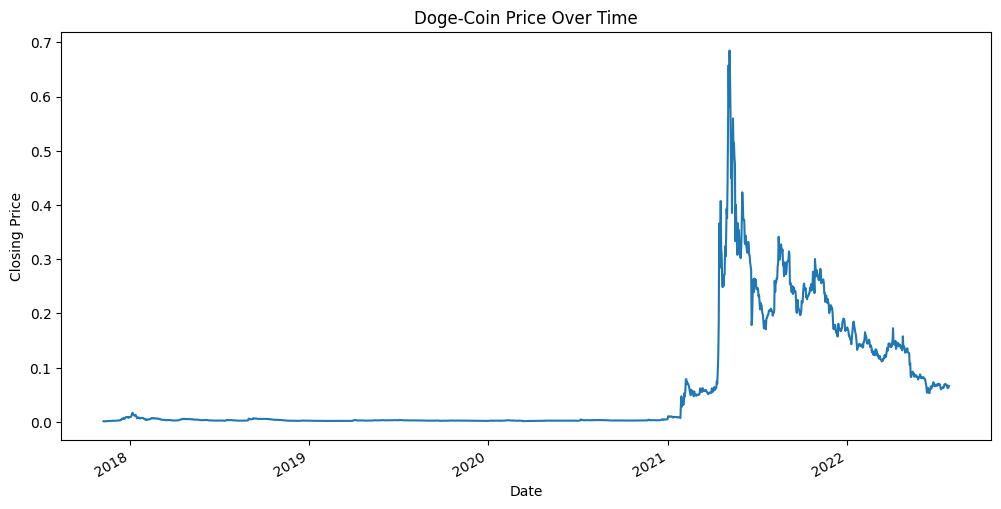

In [3]:
df['Close'].plot(figsize=(12, 6))
plt.title('Doge-Coin Price Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.show()

**NORMALIZING THE DATA**

In [4]:
scaler = MinMaxScaler(feature_range=(0, 1))
df_normalized = scaler.fit_transform(df[['Close']])


**CREATE SEQUENCES FOR THE LSTM MODEL**

In [5]:
def create_sequences(data, look_back):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back), 0])
        y.append(data[i + look_back, 0])
    return np.array(X), np.array(y)

look_back = 10
X, y = create_sequences(df_normalized, look_back)


**SPLIT THE DATA INTO TRAINING AND TESTING SETS**

In [6]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

**RESHAPE THE DATA FOR LSTM**

In [7]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

**BUILD THE LSTM MODEL**

In [8]:
model = Sequential()
model.add(LSTM(units=50, input_shape=(X_train.shape[1], 1)))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

**TRAIN THE MODEL**

In [9]:
model.fit(X_train, y_train, epochs=50, batch_size=64)

Epoch 1/50

22/22 [==============================] - 3s 5ms/step - loss: 0.0043
Epoch 2/50
22/22 [==============================] - 0s 6ms/step - loss: 0.0012
Epoch 3/50
22/22 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 4/50
22/22 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 5/50
22/22 [==============================] - 0s 4ms/step - loss: 9.9241e-04
Epoch 6/50
22/22 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 7/50
22/22 [==============================] - 0s 4ms/step - loss: 9.4025e-04
Epoch 8/50
22/22 [==============================] - 0s 5ms/step - loss: 8.9871e-04
Epoch 9/50
22/22 [==============================] - 0s 4ms/step - loss: 8.4015e-04
Epoch 10/50
22/22 [==============================] - 0s 4ms/step - loss: 8.3125e-04
Epoch 11/50
22/22 [==============================] - 0s 5ms/step - loss: 8.1671e-04
Epoch 12/50
22/22 [==============================] - 0s 4ms/step - loss: 7.6325e-04
Epoch 13/50
22/22 [=

**MAKE PREDICTIONS ON THE TEST SET**

In [10]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

11/11 [==============================] - 1s 2ms/step


**EVALUATE THE MODEL**

In [11]:
mse = mean_squared_error(df['Close'].iloc[train_size + look_back:], predictions)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.00012093326684238078


**VISUALIZE THE PREDICTIONS**

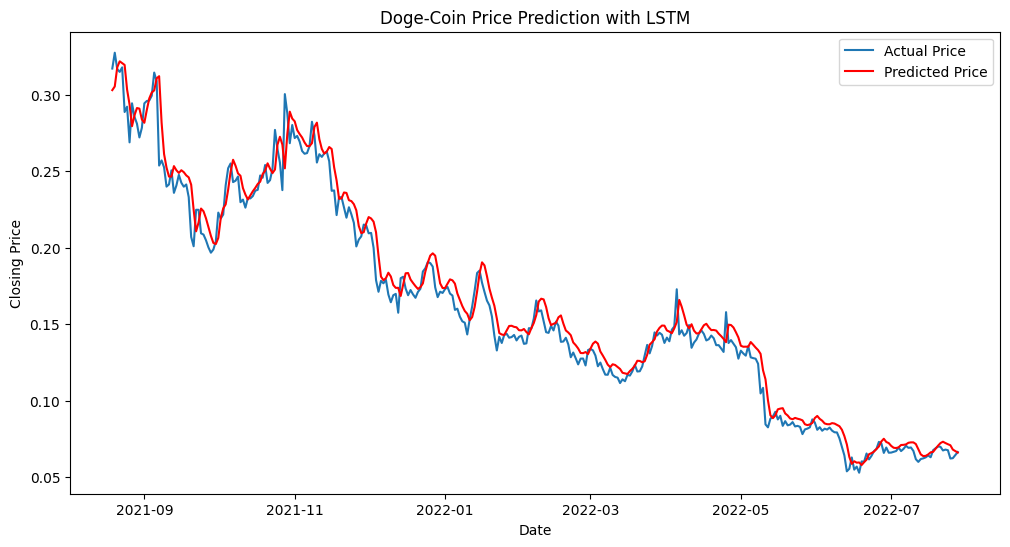

In [12]:
plt.figure(figsize=(12, 6))
plt.plot(df.index[train_size + look_back:], df['Close'].iloc[train_size + look_back:], label='Actual Price')
plt.plot(df.index[train_size + look_back:], predictions, label='Predicted Price', color='red')
plt.title('Doge-Coin Price Prediction with LSTM')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()